Options Pricing Boundaries Machine Learning Method (Lower boundary) - AOP = Multiplicator*LB

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost
import catboost
import optuna

In [6]:
# Reading files from the github repo model with bounds features
columns = ['asset_price', 'maturity', 'rate', 'div', 'ivol', 'european_op', 'american_op', 'lower_bound', 'upper_bound', 'normalized_american_op']

df = pd.read_csv('/Users/nazymazimbayev/Documents/git-projects/dataoptions/DataIn/V3.csv')
df.columns = columns

df['multiplicator'] = df['american_op'] / df['lower_bound']
df = df.drop(['upper_bound'], axis=1)
df = df.drop(['normalized_american_op'], axis=1)
df = df.drop(['american_op'], axis=1)

df.head()

,asset_price,maturity,rate,div,ivol,european_op,lower_bound,multiplicator
0,113.935171,0.285741,0.008467,0.023575,0.538127,6.612110,6.612107,1.000000
1,98.305405,0.813916,0.019547,0.018027,0.048863,2.601042,2.613173,1.005231
2,109.189731,0.713558,0.022951,0.015280,0.303538,6.397872,6.404801,1.004051
3,83.402084,2.879962,0.042272,0.058719,0.163288,20.609465,20.864488,1.001872
4,127.549831,0.907992,0.026664,0.017533,0.562713,12.093558,12.108055,1.003976


In [7]:
df['multiplicator'].describe()

count    100226.000000
mean          1.004393
std           0.015392
min           1.000000
25%           1.000006
50%           1.001372
75%           1.006462
max           2.661834
Name: multiplicator, dtype: float64

In [8]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (95215, 8)
Unseen Data For Predictions (5011, 8)


In [9]:
# Boundaries model 1 with ordinary features data preparation
from pycaret.regression import *
exp_model_dm_rt = setup(data = data, target = 'multiplicator', session_id=111, train_size = 0.95, 
                        normalize = True)

,Description,Value
0,session_id,111
1,Target,multiplicator
2,Original Data,"(95215, 8)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(90454, 7)"


In [10]:
# Creating a model with ordinary features
top3 = compare_models(n_select = 3, exclude=['et','rf'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0008,0.0000,0.0048,0.8913,0.0019,0.0008,2.3990
knn,K Neighbors Regressor,0.0007,0.0001,0.0074,0.7516,0.0031,0.0007,0.0910
xgboost,Extreme Gradient Boosting,0.0011,0.0001,0.0075,0.7294,0.0031,0.0010,3.2040
lightgbm,Light Gradient Boosting Machine,0.0013,0.0001,0.0079,0.7203,0.0033,0.0013,0.9940
gbr,Gradient Boosting Regressor,0.0021,0.0001,0.0094,0.5961,0.0040,0.0020,4.2100
ridge,Ridge Regression,0.0036,0.0002,0.0135,0.1616,0.0059,0.0034,0.0220
lr,Linear Regression,0.0036,0.0002,0.0135,0.1614,0.0059,0.0034,0.6220
lar,Least Angle Regression,0.0036,0.0002,0.0135,0.1614,0.0059,0.0034,0.0190
br,Bayesian Ridge,0.0036,0.0002,0.0135,0.1614,0.0059,0.0034,0.0390
huber,Huber Regressor,0.0028,0.0002,0.0138,0.1316,0.0060,0.0026,0.1180


In [11]:
tuned_top3 = [tune_model(i) for i in top3]
blender = blend_models(tuned_top3)
stacker = stack_models(tuned_top3)
best_mae_model = automl(optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0013,0.0000,0.0055,0.9476,0.0021,0.0012
1,0.0014,0.0001,0.0104,0.7429,0.0041,0.0013
2,0.0013,0.0001,0.0101,0.7299,0.0037,0.0012
3,0.0014,0.0000,0.0032,0.8903,0.0015,0.0014
4,0.0011,0.0000,0.0032,0.9451,0.0015,0.0011
5,0.0014,0.0000,0.0029,0.8846,0.0014,0.0014
6,0.0013,0.0000,0.0036,0.8791,0.0017,0.0013
7,0.0014,0.0000,0.0033,0.9051,0.0016,0.0014
8,0.0014,0.0000,0.0030,0.9750,0.0014,0.0014


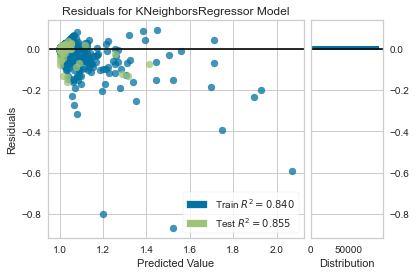

In [12]:
plot_model(best_mae_model)

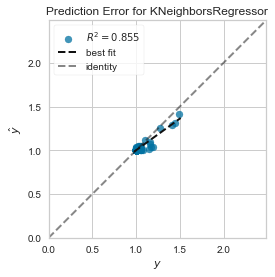

In [13]:
plot_model(best_mae_model, plot = 'error')

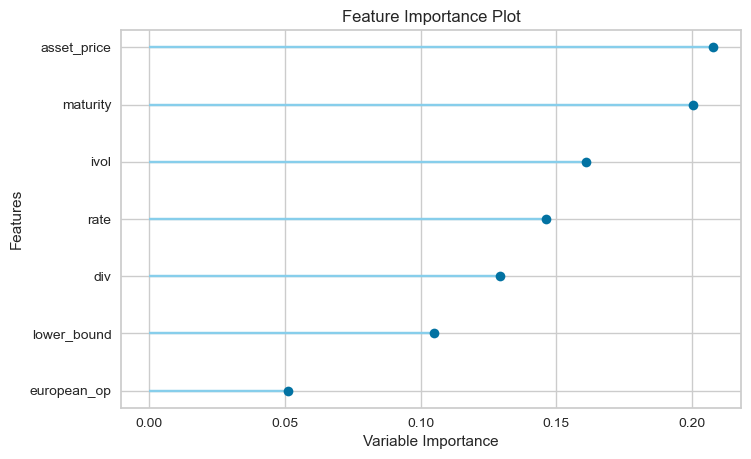

In [17]:
plot_model(tuned_top3[2], plot='feature')

In [18]:
print(best_mae_model)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')


In [19]:
save_model(best_mae_model, 'best_mae_model_indirect_lower_bound_method')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='multiplicator',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_st...
                 ('fix_perfect', Remove_100(target='multiplicator')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
  

In [20]:
final_best_model = finalize_model(best_mae_model)
print(final_best_model)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')


In [21]:
predict_model(final_best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0006,0.0000,0.0043,0.9108,0.0020,0.0006


,asset_price,maturity,rate,div,ivol,european_op,lower_bound,multiplicator,Label
0,0.974746,-0.771208,-0.661431,2.272162,0.448551,-1.132289,-1.147461,1.000000,1.000001
1,0.387746,-0.402196,-0.333157,-0.367517,-0.554285,-0.871814,-0.891632,1.002461,1.002510
2,-1.638309,-0.796452,-0.868309,-0.266245,-1.411231,1.352255,1.288337,1.000000,1.000000
3,-0.671752,-0.668805,0.749662,-0.529115,1.539778,0.408394,0.373094,1.005528,1.004175
4,0.836073,-0.504052,2.274875,1.164865,0.591609,-0.751905,-0.769017,1.009687,1.009870
...,...,...,...,...,...,...,...,...,...
4756,1.467124,-0.841321,-1.360488,0.989321,0.102784,-1.432327,-1.441609,1.000004,1.000002
4757,-1.215296,-0.576929,0.614996,2.064034,-2.174488,0.730379,0.678663,1.000000,1.000000
4758,-0.382723,0.404354,-1.352947,0.539229,0.216992,1.056861,0.998733,1.000000,1.000004
4759,0.695367,-0.334968,-1.098904,-0.455906,0.037011,-0.633729,-0.658680,1.000005,1.000007


In [22]:
unseen_predictions = predict_model(final_best_model, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0009,0.0001,0.0084,0.5476,0.0038,0.0008


,asset_price,maturity,rate,div,ivol,european_op,lower_bound,multiplicator,Label
0,85.411375,0.467677,0.003564,0.097180,0.102791,18.220903,18.220903,1.000000,1.000000
1,86.928069,0.701853,0.029514,0.038928,0.018545,13.364723,13.364723,1.000000,1.000000
2,106.802615,0.665436,0.007637,0.020037,0.238684,5.340597,5.340597,1.000008,1.000005
3,74.557547,0.680546,0.024866,0.002517,0.103077,23.893106,25.442390,1.000000,1.004054
4,113.842459,4.721544,0.025811,0.044534,0.271343,19.143581,19.273635,1.002763,1.002959


In [23]:
all_predictions = predict_model(final_best_model, data=df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0006,0.0000,0.0063,0.8345,0.0025,0.0005


In [24]:
all_predictions['american_op'] = all_predictions['multiplicator'] * all_predictions['lower_bound']
all_predictions['predicted_american_op'] = all_predictions['Label'] * all_predictions['lower_bound']

In [25]:
all_predictions.head()

,asset_price,maturity,rate,div,ivol,european_op,lower_bound,multiplicator,Label,american_op,predicted_american_op
0,113.935171,0.285741,0.008467,0.023575,0.538127,6.612110,6.612107,1.000000,1.000009,6.612107,6.612168
1,98.305405,0.813916,0.019547,0.018027,0.048863,2.601042,2.613173,1.005231,1.004479,2.626842,2.624877
2,109.189731,0.713558,0.022951,0.015280,0.303538,6.397872,6.404801,1.004051,1.003610,6.430745,6.427924
3,83.402084,2.879962,0.042272,0.058719,0.163288,20.609465,20.864488,1.001872,1.002026,20.903553,20.906756
4,127.549831,0.907992,0.026664,0.017533,0.562713,12.093558,12.108055,1.003976,1.003951,12.156191,12.155892


In [27]:
# Final errors calcualtions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("MSE =", mean_squared_error(all_predictions['american_op'], all_predictions['predicted_american_op']))
print("MAE =", mean_absolute_error(all_predictions['american_op'], all_predictions['predicted_american_op']))

MSE = 0.006786834610821559
MAE = 0.009070701981695335


In [28]:
#all predictions to csv
all_predictions.to_csv('/Users/nazymazimbayev/Documents/git-projects/dataoptions/DataOut/all_predictions(indirect_method_lower_bound).csv')